In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso,\
Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [2]:
housing = pd.read_csv('./datasets/train.csv')

In [3]:
housing.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

# EDA

In [4]:
# Create mask for numeric and categorical features
num_features = [col for col in housing._get_numeric_data().columns]
cat_features = [col for col in housing.select_dtypes(include=['object']).columns]

## Numerical Feature Scatterplots

In [5]:
# Create function to make plots of each feature vs SalePrice
def eda_scatplot(dataframe, list_of_columns, target):
    nrows = int(np.ceil(len(list_of_columns)/4))
    ncols = 4
    fig, ax = plt.subplots(nrows=nrows, 
                           ncols=ncols, 
                           figsize=(14, nrows*2.5))
    ax = ax.ravel()
    
    for i, column in enumerate(list_of_columns):
        g = sns.regplot(data=dataframe, 
                        x=column, 
                        y=target, 
                        ax=ax[i], 
                        ci=None, 
                        color='skyblue', 
                        line_kws={'color': 'red'})
        ax[i].set_title(column, fontsize=14)
        ax[i].set_xlabel('')
        plt.tight_layout()
        
    plt.suptitle('Variables\' Effects on SalePrice', fontsize=20, y=1.015)


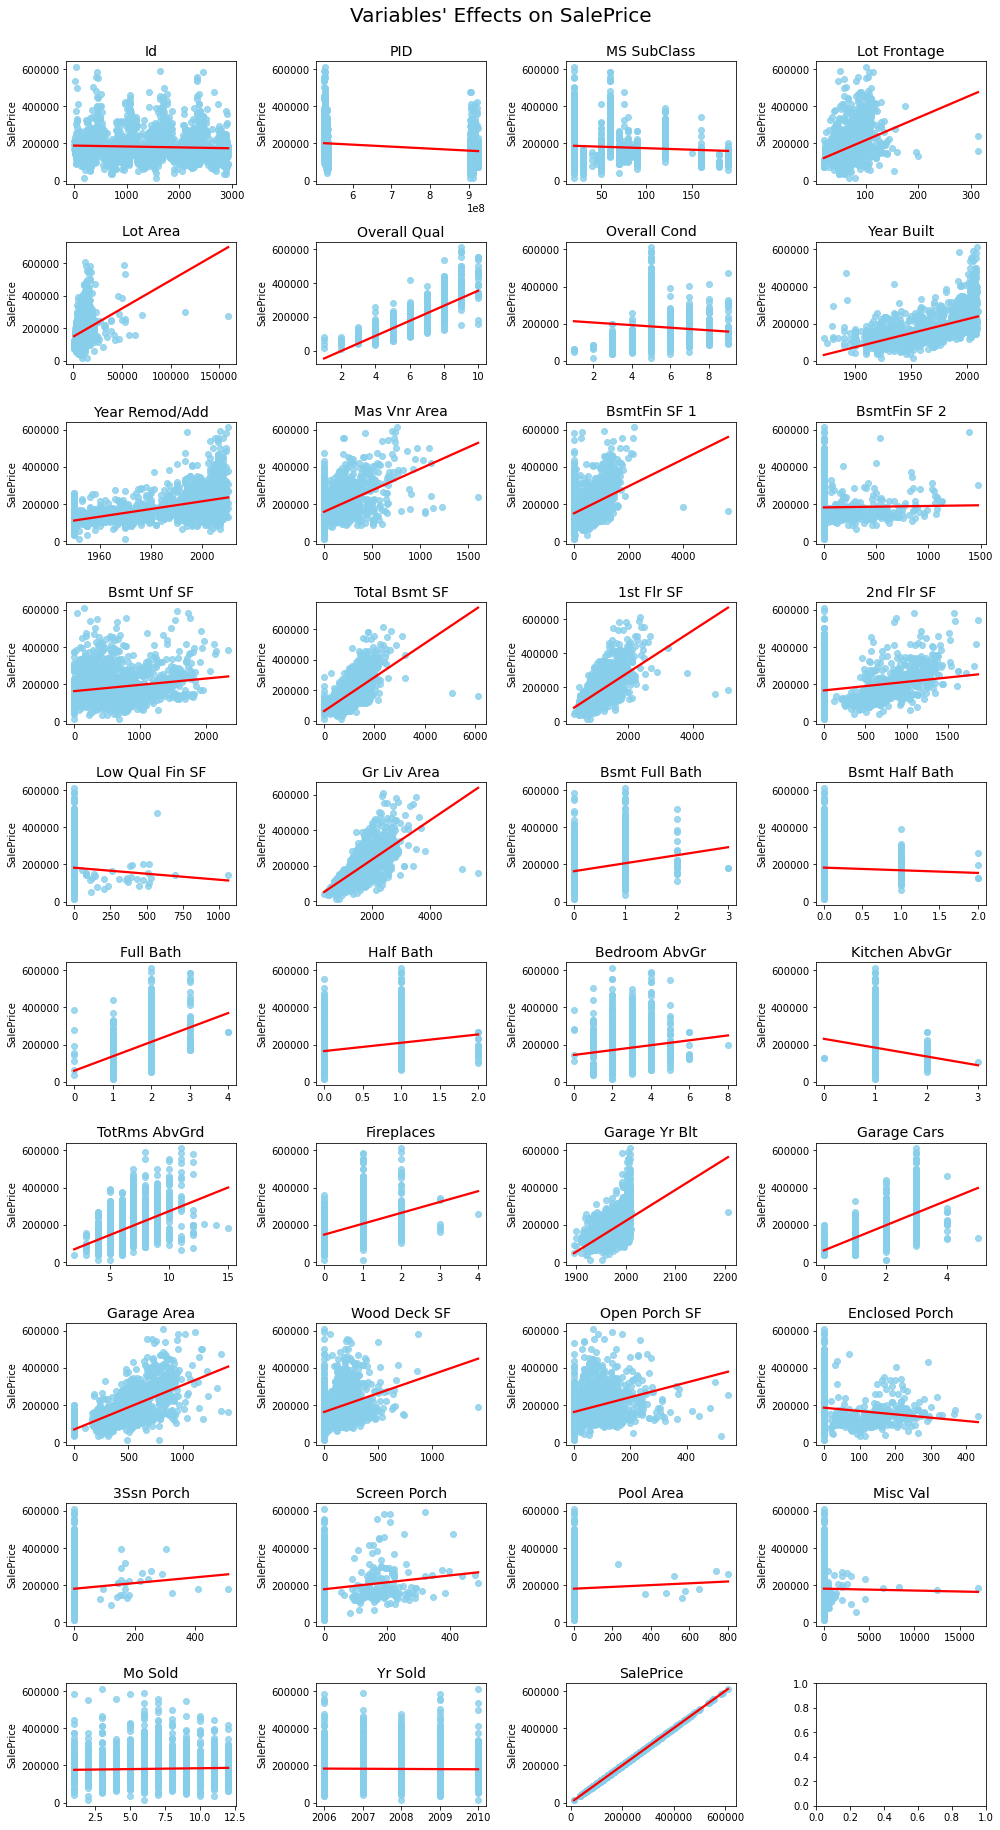

In [6]:
eda_scatplot(housing, num_features, 'SalePrice')

`Gr Liv Area`, `Garage Area` and square feet in general have a very positive correlation with Sale Price, which is unsurprising because it makes sense that a bigger house would generally be more expensive. `Year Built` also has a positive correlation with sale price according to the graphs.

## Numerical Feature Histograms

In [7]:
def eda_hist(dataframe, list_of_columns):
    nrows = int(np.ceil(len(list_of_columns)/5)) 
    ncols = 5
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14, nrows*2.5)) 
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.histplot(data=housing, 
                     x=dataframe[column], 
                     kde=False, 
                     ax=ax[i], 
                     fill=False)
        ax[i].set_title(column,fontsize=14)
        ax[i].set_xlabel('')
        ax[i].tick_params(labelsize=10)
    plt.tight_layout(h_pad=-0.4, w_pad=-0.4)
    
    plt.suptitle('Variables\' Effects on SalePrice', fontsize=20, y=1.015)

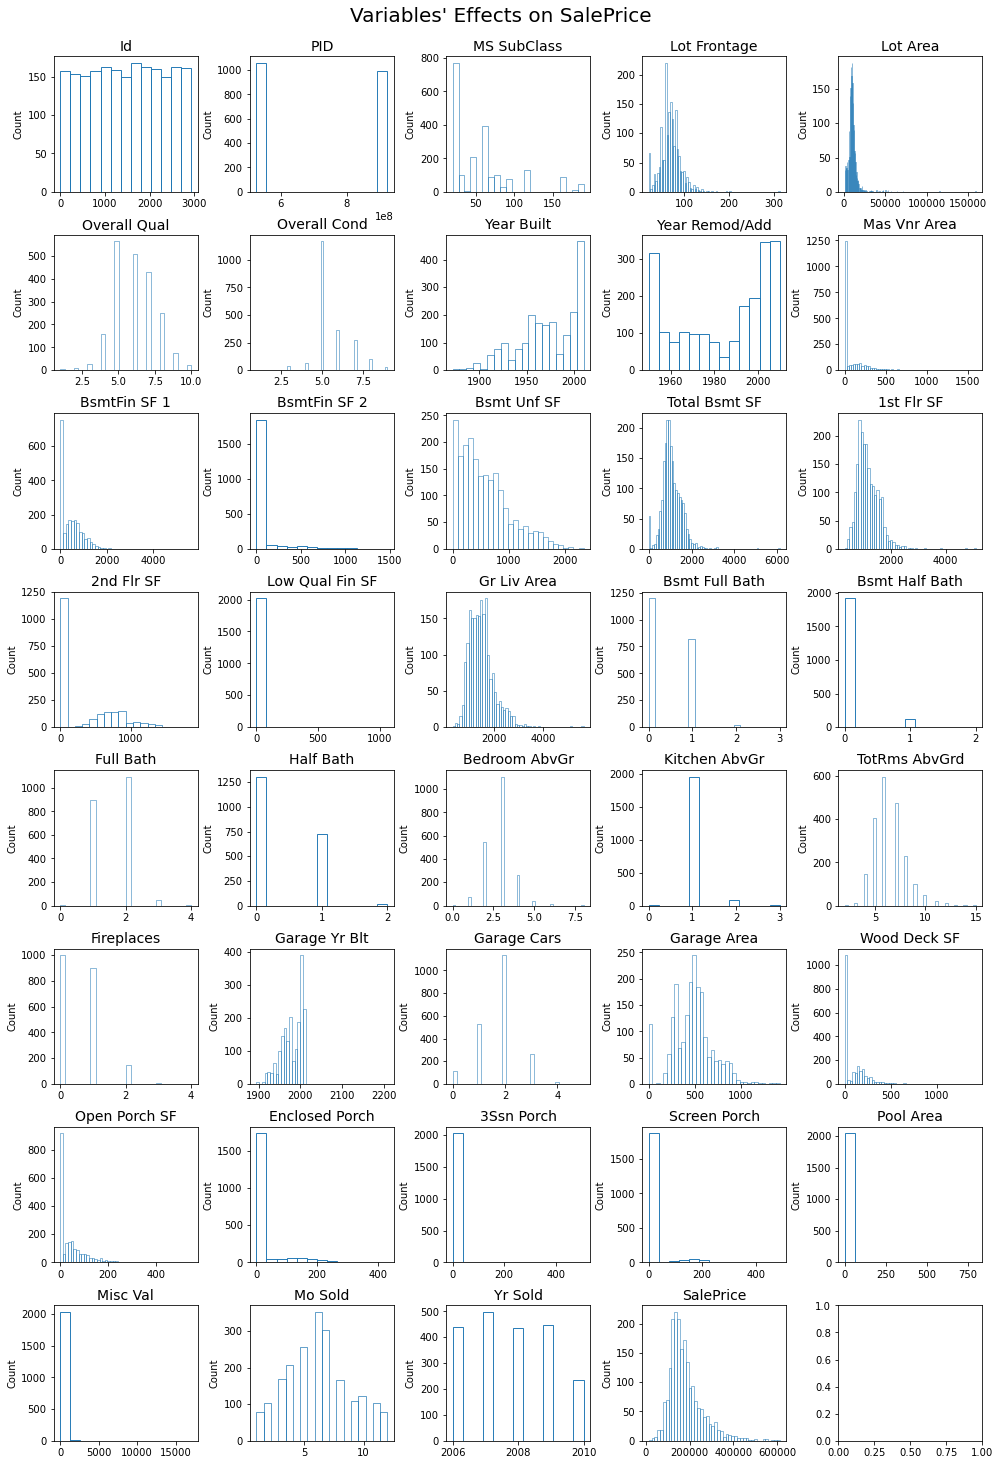

In [8]:
eda_hist(housing, num_features)

Looking at these histograms, we can see that many features/variables are right skewed.It seems like there are several features with few extremely high values which can mess with our data. It is important to revisit those and decide what to do with them later on.

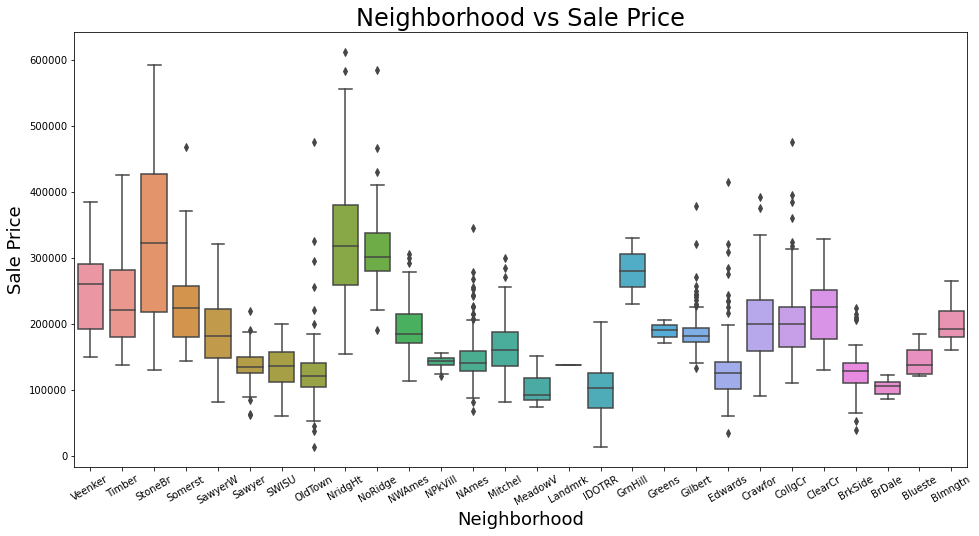

In [9]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=housing, x=housing['Neighborhood']\
            .sort_values(ascending=False), y='SalePrice')
plt.xticks(rotation=30)
plt.title('Neighborhood vs Sale Price', fontsize = 24)
plt.ylabel('Sale Price', fontsize = 18)
plt.xlabel('Neighborhood', fontsize = 18);

Looking at different neighborhoods within our dataset, we can see that there are some neighborhoods with a lower median sale price compared to others, but outliers that sell higher than the same comparative neighborhoods. This could mean that although neiborhoods could influence the sale price, there is no strong indication from just what we see here.

## Multiple linear regression analysis requirements:

1) Must have linear relationship between outcome variables and independent variables

2) Must have multivariate normality, as multiple regression assumes that residuals are normally distributed.

3) Cannot have multicollinearity. Multiple regression assumes independent variables are not highly correlated with each other.

### Checking Multicollinearity

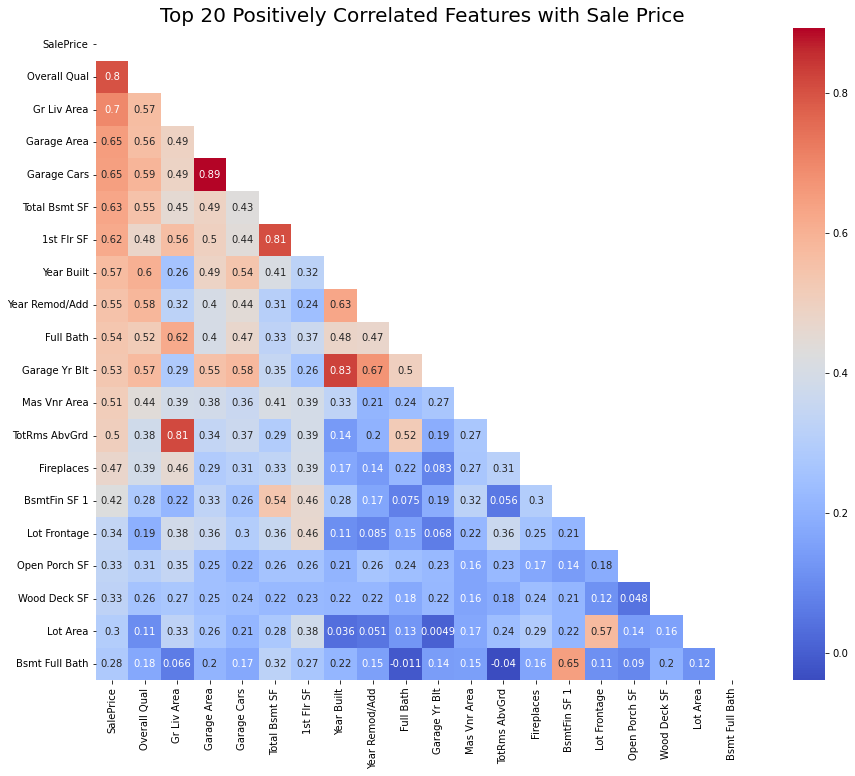

In [10]:
# Create mask for our top twenty positively correlated features
top_corr = housing.corr()['SalePrice'].sort_values(ascending=False).head(20).index

# Top twenty positively correlated features.
plt.figure(figsize=(16,12))
mask = np.triu(np.ones_like(housing[top_corr].corr(), dtype=bool))
ax = sns.heatmap(housing[top_corr].corr(), cmap='coolwarm', mask=mask, square=True, annot=True)
plt.title('Top 20 Positively Correlated Features with Sale Price', fontsize=20);

According to the heatmap, it seems like there is some multicollinearity with our variables which is not ideal.

4) Independent variables must be homoscedastic. Variance of error terms must be similar across values of independent variables.

### Checking for Homoscedascity

In [11]:
# Create copy of data set to not alter dataset
housing1 = housing.fillna(0)

In [12]:
# Create baseline linear model
features = [col for col in housing._get_numeric_data().columns if col !='SalePrice']
features
X = housing1[features]
y = housing1['SalePrice']

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

In [13]:
# Our baseline model can explain 84% of the variance in sale price.
# Our baseline model also has an RSME of over 30,000.
# Using this as our Kaggle model returns an RSME of over 45,000.
print('R2:', lr.score(X, y))
print('RMSE:', np.sqrt(mean_squared_error(y, y_pred)))

R2: 0.8410808671827918
RMSE: 31588.493600183727


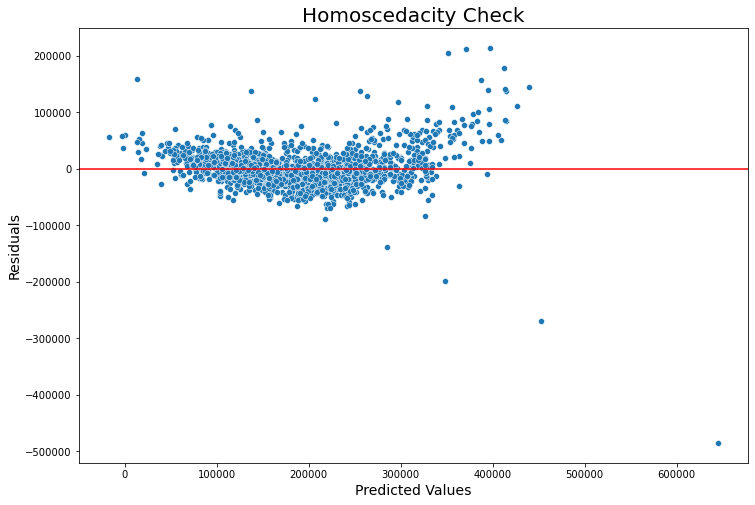

In [14]:
# Plotting residuals -- they seem to be evenly distributed with no discernable pattern
plt.figure(figsize=(12,8))
ax = sns.scatterplot(data=X, x=y_pred, y=y-y_pred)
ax.axhline(y=0, c='red')
plt.title('Homoscedacity Check', fontsize=20)
plt.ylabel('Residuals', fontsize=14)
plt.xlabel('Predicted Values', fontsize=14);

According to the dataset, linear regression is definitely possible. There is a need to reduce multicollinearity as observed in the heatmap. This should be possible with data cleaning. After that, there should be an accurate model that is able to predict sale price.

# Data Cleaning

In [15]:
# Load in test dataset - we already loaded in train set earlier as housing
# housing = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [16]:
housing.shape

(2051, 81)

In [17]:
housing.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,2051.0,1.474034e+03,8.439808e+02,1.0,753.5,1486.0,2.198000e+03,2930.0
PID,2051.0,7.135900e+08,1.886918e+08,526301100.0,528458140.0,535453200.0,9.071801e+08,924152030.0
MS SubClass,2051.0,5.700878e+01,4.282422e+01,20.0,20.0,50.0,7.000000e+01,190.0
Lot Frontage,1721.0,6.905520e+01,2.326065e+01,21.0,58.0,68.0,8.000000e+01,313.0
Lot Area,2051.0,1.006521e+04,6.742489e+03,1300.0,7500.0,9430.0,1.151350e+04,159000.0
Overall Qual,2051.0,6.112140e+00,1.426271e+00,1.0,5.0,6.0,7.000000e+00,10.0
Overall Cond,2051.0,5.562165e+00,1.104497e+00,1.0,5.0,5.0,6.000000e+00,9.0
Year Built,2051.0,1.971709e+03,3.017789e+01,1872.0,1953.5,1974.0,2.001000e+03,2010.0
Year Remod/Add,2051.0,1.984190e+03,2.103625e+01,1950.0,1964.5,1993.0,2.004000e+03,2010.0
Mas Vnr Area,2029.0,9.969591e+01,1.749631e+02,0.0,0.0,0.0,1.610000e+02,1600.0


## Looking at null and zero values

In [18]:
# Create mask to find variables with null values
null_values = housing.isnull().sum()[housing.isnull().sum() > 0].sort_values(ascending=False)

In [19]:
# Create dictionary of null values
null_dict = {f'{col}': housing[col].isnull().sum() for col in null_values.index}

# Find exact percentages of null values
print('NaN Values', end='\n--------------\n')
for key, value in null_dict.items():
    x = value / len(housing)
    print(f'{key}: {value}/{len(housing)} - {x*100:.2f}%')

NaN Values
--------------
Pool QC: 2042/2051 - 99.56%
Misc Feature: 1986/2051 - 96.83%
Alley: 1911/2051 - 93.17%
Fence: 1651/2051 - 80.50%
Fireplace Qu: 1000/2051 - 48.76%
Lot Frontage: 330/2051 - 16.09%
Garage Yr Blt: 114/2051 - 5.56%
Garage Cond: 114/2051 - 5.56%
Garage Qual: 114/2051 - 5.56%
Garage Finish: 114/2051 - 5.56%
Garage Type: 113/2051 - 5.51%
Bsmt Exposure: 58/2051 - 2.83%
BsmtFin Type 2: 56/2051 - 2.73%
Bsmt Cond: 55/2051 - 2.68%
Bsmt Qual: 55/2051 - 2.68%
BsmtFin Type 1: 55/2051 - 2.68%
Mas Vnr Area: 22/2051 - 1.07%
Mas Vnr Type: 22/2051 - 1.07%
Bsmt Half Bath: 2/2051 - 0.10%
Bsmt Full Bath: 2/2051 - 0.10%
Total Bsmt SF: 1/2051 - 0.05%
Bsmt Unf SF: 1/2051 - 0.05%
BsmtFin SF 2: 1/2051 - 0.05%
Garage Cars: 1/2051 - 0.05%
Garage Area: 1/2051 - 0.05%
BsmtFin SF 1: 1/2051 - 0.05%


During initial inspection on our null values, there are 5 features  we must address.

1) `Pool QC` has a very high rate of null values.

2) `Misc Feature` contains variables that are not covered in other categories such as elevator, 2nd garage, shed, tennis court etc.

3) `Alley` looks at type of alley access to the property:

    - Gravel(Grvl)
    - Paved(Pave)
    
4) `Fence` looks at the quality of the fence and its ability to provide privacy from Good Privacy to the null value stating there is no fence

5) `Fireplace Qu` looks at the quality of the fireplace ranging from Excellent to NA meaning no fireplace

These values have the highest rate of missing values from our features.

In [20]:
# Create mask to find all variables with zero values
zero_values = housing.isin([0]).sum().sort_values(ascending=False)
zero_values = zero_values[zero_values > 0]

In [21]:
# Create dictionary of zero values
zero_dict = {f'{col}': housing[col].isin([0]).sum() for col in zero_values.index}

# Find percentages of zero values
print('Number of zeros', end='\n--------------\n')
for key, value in zero_dict.items():
    x = value / len(housing)
    print(f'{key}: {value}/{len(housing)} - {x*100:.2f}%')

Number of zeros
--------------
Pool Area: 2042/2051 - 99.56%
3Ssn Porch: 2025/2051 - 98.73%
Low Qual Fin SF: 2018/2051 - 98.39%
Misc Val: 1986/2051 - 96.83%
Bsmt Half Bath: 1923/2051 - 93.76%
Screen Porch: 1870/2051 - 91.18%
BsmtFin SF 2: 1803/2051 - 87.91%
Enclosed Porch: 1724/2051 - 84.06%
Half Bath: 1308/2051 - 63.77%
Mas Vnr Area: 1216/2051 - 59.29%
Bsmt Full Bath: 1200/2051 - 58.51%
2nd Flr SF: 1191/2051 - 58.07%
Wood Deck SF: 1075/2051 - 52.41%
Fireplaces: 1000/2051 - 48.76%
Open Porch SF: 912/2051 - 44.47%
BsmtFin SF 1: 657/2051 - 32.03%
Bsmt Unf SF: 165/2051 - 8.04%
Garage Area: 113/2051 - 5.51%
Garage Cars: 113/2051 - 5.51%
Total Bsmt SF: 54/2051 - 2.63%
Full Bath: 8/2051 - 0.39%
Bedroom AbvGr: 5/2051 - 0.24%
Kitchen AbvGr: 2/2051 - 0.10%


Looking at the comparison between null values and `0` values, we can see that there are some features that have identical amount of both. For example, `Pool QC` has 2042 null values as well as `0` values.

## Outliers

It was noted in the documentation of the housing data that there are 5 outliers we must look at. It was suggested that those are dropped for more accurate representation of the data as a whole, so we will do that here.

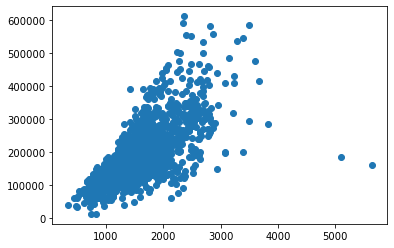

In [22]:
plt.scatter(housing['Gr Liv Area'], housing['SalePrice']);

In [23]:
# dropping houses that have greater than 4000 sq feet
housing.drop(housing[housing['Gr Liv Area'] > 4000].index, inplace = True)

In [24]:
(housing['Gr Liv Area'] > 4000).sum()

0

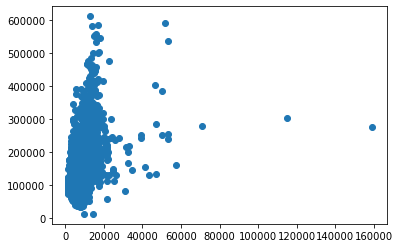

In [25]:
plt.scatter(housing['Lot Area'], housing['SalePrice']);

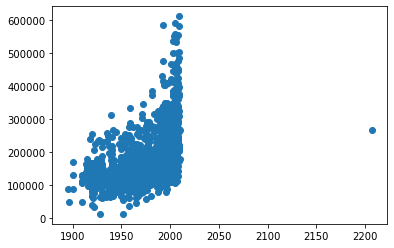

In [26]:
plt.scatter(housing['Garage Yr Blt'], housing['SalePrice']);

It seems like there was a typo for one of the houses, the value being 2207. I believe it is safe to conclude that the data meant to state 2007.

In [27]:
# Changing the value
housing['Garage Yr Blt'].replace({2207: 2007}, inplace=True)

## Cleaning Null Values

### Pool Quality

In [28]:
housing['Pool QC'] = housing['Pool QC'].fillna('None')
housing['Pool QC'] = housing['Pool QC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0})

### Misc Feature

In [29]:
# One hot encoding for nominal variable
housing = pd.get_dummies(housing, columns=['Misc Feature']).drop('Misc Feature_Othr', axis=1)

### Alleys and Fences

In [30]:
housing['Fence'] = housing['Fence'].fillna('None')
housing['Fence'] = housing['Fence'].map({'GdPrv':3,'MnPrv':2,'GdWo':1,'MnWw':1,'None':0})

### Fireplace Quality and Lot Frontage


In [31]:
housing['Fireplace Qu'] = housing['Fireplace Qu'].fillna('None')
housing['Fireplace Qu'] = housing['Fireplace Qu'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})

We have several ways of imputing missing values for Lot frontage, but I believe it would be for the best to use the average lot frontage of the property's neighborhood.

In [32]:
# Function to estimate lot frontage based on average of houses in neighborhood or township + section
def lot_frontage_gen(row):
    if np.isnan(row['Lot Frontage']):
        neighborhood = row['Neighborhood']
        nbrhd_std = housing[housing['Neighborhood'] == \
                            neighborhood]['Lot Frontage'].std()
        lot_frontage_mean = housing[housing['Neighborhood'] == \
                                    neighborhood]['Lot Frontage'].mean()
        
        try:
            # Add in slight randomness to prevent understimation of variance
            row['Lot Frontage'] = lot_frontage_mean + \
            np.random.randint(-nbrhd_std, nbrhd_std) / 1.25
        
        # If neighborhood is NAN
        except:
            pid = str(row['PID'])
            print(pid, '-- Neighborhood N/A -- imputing township average')
            sliced_pid = pid[0:3]
            lot_frontage_mean = housing[housing['PID'].astype(str).str.contains(sliced_pid)]['Lot Frontage'].mean()
            row['Lot Frontage'] = lot_frontage_mean
            
    return row

In [33]:
housing = housing.apply(lot_frontage_gen, axis=1)

916253320 -- Neighborhood N/A -- imputing township average
907230240 -- Neighborhood N/A -- imputing township average
916252170 -- Neighborhood N/A -- imputing township average


### Garage Finish, Condition, Quality, Yr Built, Type

In [34]:
housing[housing['Garage Area'] == 0]\
[housing.columns[housing.columns.str.contains('Garage')]].count()

Garage Type        0
Garage Yr Blt      0
Garage Finish      0
Garage Cars      113
Garage Area      113
Garage Qual        0
Garage Cond        0
dtype: int64

There are 113 properties with no garage.


In [35]:
housing['Garage Type'] = housing['Garage Type'].fillna('None')
housing['Garage Finish'] = housing['Garage Finish'].fillna('None')
housing['Garage Qual'] = housing['Garage Qual'].fillna('None')
housing['Garage Cond'] = housing['Garage Cond'].fillna('None')

In [36]:
# make dummy variables of Garage Type
housing = pd.get_dummies(housing, columns=['Garage Type']).drop('Garage Type_None', axis=1)

In [37]:
# impute Garage Yr Blt with values of House Year Built
housing['Garage Yr Blt'] = housing['Garage Yr Blt'].fillna(housing['Year Built'])

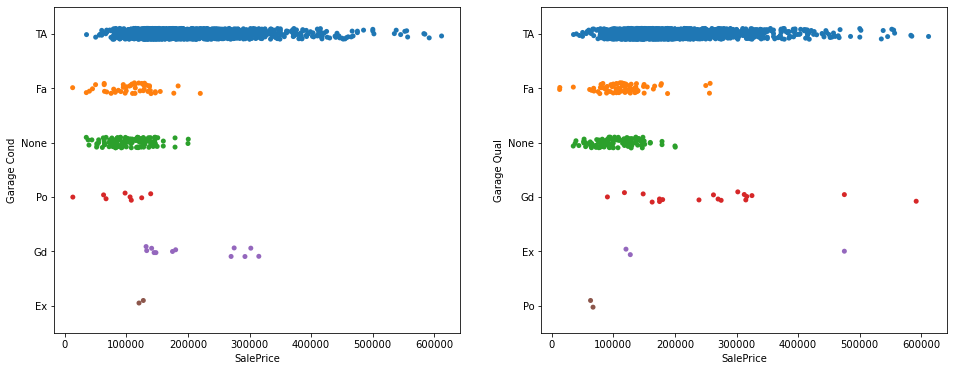

In [38]:
# Plot to demonstrate why we might choose not to use the 
# conventional 5>4>3>2>1>0 scalefor certain variables

# Here, we can see that most houses fall into the 'TA' category.
# This will be our 0 standard.

fig, ax = plt.subplots(ncols=2, figsize=(16,6))
ax = ax.ravel()
sns.stripplot(data=housing, x='SalePrice', y='Garage Cond', ax=ax[0])
sns.stripplot(data=housing, x='SalePrice', y='Garage Qual', ax=ax[1]);

In [39]:
# Encode ordinal variables as integers
# Given that the majority of houses fall into the average (TA) category, we'll set that as 0.
# We'll also look to give houses with fair and no garages the a similar rating, given that they have a similar range & median. 
housing['Garage Cond'] = housing['Garage Cond'].map({'Ex':2,'Gd':1,'TA':0,'None':-0.5,'Fa':-0.5,'Po':-1,})
housing['Garage Qual'] = housing['Garage Qual'].map({'Ex':2,'Gd':1,'TA':0,'None':-0.5,'Fa':-0.5,'Po':-1,})
housing['Garage Finish'] = housing['Garage Finish'].map({'Fin':3,'RFn':2,'Unf':1,'None':0})


In [40]:
# There's one property that has null values for Garage Cars and Area 
# We'll update this according to info from the Ames assessor website
housing[housing['Garage Cars'].isnull() == True][housing.columns[housing.columns.str.contains('Garage')]]


,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd
1712,1923.0,0,NaN,NaN,-0.5,-0.5,0,0,0,0,0,1


This garage is 280 sqaure foot, fits 1 car, and is attached. It was built in 1952. We will edit the features according to the PID of the house.

In [41]:
housing.at[1712, 'Garage Yr Blt'] = 1952
housing.at[1712, 'Garage Cars'] = 1
housing.at[1712, 'Garage Area'] = 280
housing.at[1712, 'Garage Type_Detchd'] = 0
housing.at[1712, 'Garage Type_Attchd'] = 1

### Basement Exposure, Condition, Type, Quality

In [42]:
housing[housing['Total Bsmt SF'] == 0][housing.columns[housing.columns.str.contains('Bsmt')]].count()


Bsmt Qual          0
Bsmt Cond          0
Bsmt Exposure      0
BsmtFin Type 1     0
BsmtFin SF 1      54
BsmtFin Type 2     0
BsmtFin SF 2      54
Bsmt Unf SF       54
Total Bsmt SF     54
Bsmt Full Bath    53
Bsmt Half Bath    53
dtype: int64

Like the garage variables, the basement variables have null values for no basement.

In [43]:
# Fix ordinal basement variables
housing['Bsmt Qual'] = housing['Bsmt Qual'].fillna('None')
housing['Bsmt Cond'] = housing['Bsmt Cond'].fillna('None')
housing['Bsmt Exposure'] = housing['Bsmt Exposure'].fillna('None')
housing['BsmtFin Type 1'] = housing['BsmtFin Type 1'].fillna('None')
housing['BsmtFin Type 2'] = housing['BsmtFin Type 2'].fillna('None')

In [44]:
# As most basements have a condition of 0, we're using it as the 
# standard and working backwards from there.

# Moving from a 5>4>3>2>1>0 standard to a 2>1>0>-0.25>-0.5>-1 
# standard greatly improved the accuracy of my model.
housing['Bsmt Cond'] = housing['Bsmt Cond'].map\
({'Ex':2,'Gd':1,'TA':0, 'Fa':-0.25, 'None':-0.5, 'Po':-1})
housing['Bsmt Exposure'] = housing['Bsmt Exposure'].map\
({'Gd':3,'Av':2,'Mn':1,'No':0,'None':0})

#basements of excellent quality (or height) tend to have much higher sales prices.
housing['Bsmt Qual'] = housing['Bsmt Qual'].map\
({'Ex':4,'Gd':2,'TA':0, 'Fa':-0.25, 'None':-0.5, 'Po':-1})

# Only good quality basements seem to have a strong correlation with higher sales prices.
housing['BsmtFin Type 1'] = housing['BsmtFin Type 1'].map\
({'GLQ':3,'ALQ':2,'BLQ':1,'Rec':1,'LwQ':0.5,'Unf':0,'None':-0.5})
housing['BsmtFin Type 2'] = housing['BsmtFin Type 2'].map\
({'GLQ':3,'ALQ':2,'BLQ':1,'Rec':1,'LwQ':0.5,'Unf':0,'None':-0.5})


In [45]:
# There are 2 properties that have null values for other
# basement variables
housing[housing['Bsmt Full Bath'].isnull() == True]\
[housing.columns[housing.columns.str.contains('Bsmt')]]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
616,-0.5,-0.5,0,-0.5,0.0,-0.5,0.0,0.0,0.0,NaN,NaN
1327,-0.5,-0.5,0,-0.5,NaN,-0.5,NaN,NaN,NaN,NaN,NaN


The first house's total basement SF appears to be 0 which means there is no basement.

In [46]:
housing['Bsmt Full Bath'] = housing['Bsmt Full Bath'].fillna(0)
housing['Bsmt Half Bath'] = housing['Bsmt Half Bath'].fillna(0)

The second property's PID shows that it also does not have a basement. All discrete variables will be set to 0

In [47]:
housing[housing.columns[housing.columns.str.contains('Bsmt')]] = \
housing[housing.columns[housing.columns.str.contains('Bsmt')]].fillna(0)

### Masonry Veneer Type and Area

The PID of the houses with NaN's for the `Mas Vnr Type` and `Mas Vnr Area` do not have Masonry Veneers. We will set these values to none/0.

In [48]:
housing['Mas Vnr Type'] = housing['Mas Vnr Type'].fillna('None')

# There's no clear order here, so we'll use one hot encoding.
housing = pd.get_dummies(data=housing, columns=['Mas Vnr Type'])\
.drop('Mas Vnr Type_None', axis=1)

In [49]:
housing['Mas Vnr Area'] = housing['Mas Vnr Area'].fillna(0)

## Encoding Categorical Features

There are 27 categorical features left at this point of data cleaning: 10 ordinal and 17 nominal.

In [50]:
ordinal_feats = ['Lot Shape', 'Utilities', 'Land Slope', 'Exter Qual', 'Exter Cond', 
                 'HeatingQC', 'Electrical', 'Kitchen Qual', 'Functional', 'Paved Drive']

### Lot Shape, Land Slope

Lot shape seems to have little correlation with sale price. Irregular lotted houses have higher median prices which could mean that people want to pay more for more of a unique lot shape. Land Slope seems to follow a similar pattern.


In [51]:
housing['Lot Shape'] = housing['Lot Shape'].map({'IR1':1,'IR2':1,'IR3':1,'Reg':0})


In [52]:
housing['Land Slope'] = housing['Land Slope'].map({'Gtl':0,'Mod':1,'Sev':1})


### Utilities, Heating QC, Electrical

Utilities will have marginal impact on sale price as most will use public utilities. We may have to drop these features later on, but will map them just in case there is a correlation found.

Heating QC has a much higher median sale price if the quality is excellent.

A large majority of houses have standard circuit breakers. Houses without circuit breakers have a lower median sales price to no one's surprise

In [53]:
housing['Utilities'] = housing['Utilities'].map\
({'AllPub':0,'NoSewr':-1,'NoSeWa':-1})

housing['Heating QC'] = housing['Heating QC'].map\
({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})

housing['Electrical'] = housing['Electrical'].map\
({'SBrkr':1,'FuseA':0.5,'FuseF':0,'FuseP':0,'Mix':0})


### External Quality and Condition

Exter Qual evaluates the quality of the material on the exterior. The higher the quality, the higher median sale price in general.

Exter Cond has a similar relationship, albeit a little weaker.

In [54]:
housing['Exter Qual'] = housing['Exter Qual'].map\
({'Ex':2,'Gd':1,'TA':0,'Fa':-1,'Po':-2})

housing['Exter Cond'] = housing['Exter Cond'].map\
({'Ex':2,'Gd':1,'TA':0,'Fa':-1,'Po':-2})


### Kitchen Quality

We see that the higher the quality of the kitchen, the higher the median sale price tends to be.

In [55]:
housing['Kitchen Qual'] = housing['Kitchen Qual'].map\
({'Ex':4.5,'Gd':3,'TA':2,'Fa':1,'Po':0})

### Functional and Paved Drive

Almost all houses have a typical level of functionality. It would be best to weigh the defected houses accordingly.

We will also weigh the no paved drive a slightly more negative.

In [56]:
housing['Functional'] = housing['Functional'].map\
({'Typ':1,'Min1':0,'Min2':0,'Mod':-2,'Maj1':-3,'Maj2':-3,'Sev':-6,'Sal':-8})

housing['Paved Drive'] = housing['Paved Drive'].map\
({'Y':1,'P':0.5,'N':0})


## Encoding Nominal Variables



In [57]:
cat_features = [col for col in housing.select_dtypes(include=['category', 'object']).columns]
cat_features

['MS Zoning',
 'Street',
 'Alley',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air',
 'Sale Type']

In [58]:
housing = pd.get_dummies(data=housing, columns=cat_features)

In [59]:
housing.isnull().sum().max()


0

## Changing Nominal to Categorical Feature

In [60]:
housing = pd.get_dummies(data=housing, columns=['MS SubClass'])

In [61]:
# 2049 properties, 228 features
housing.shape

(2049, 228)

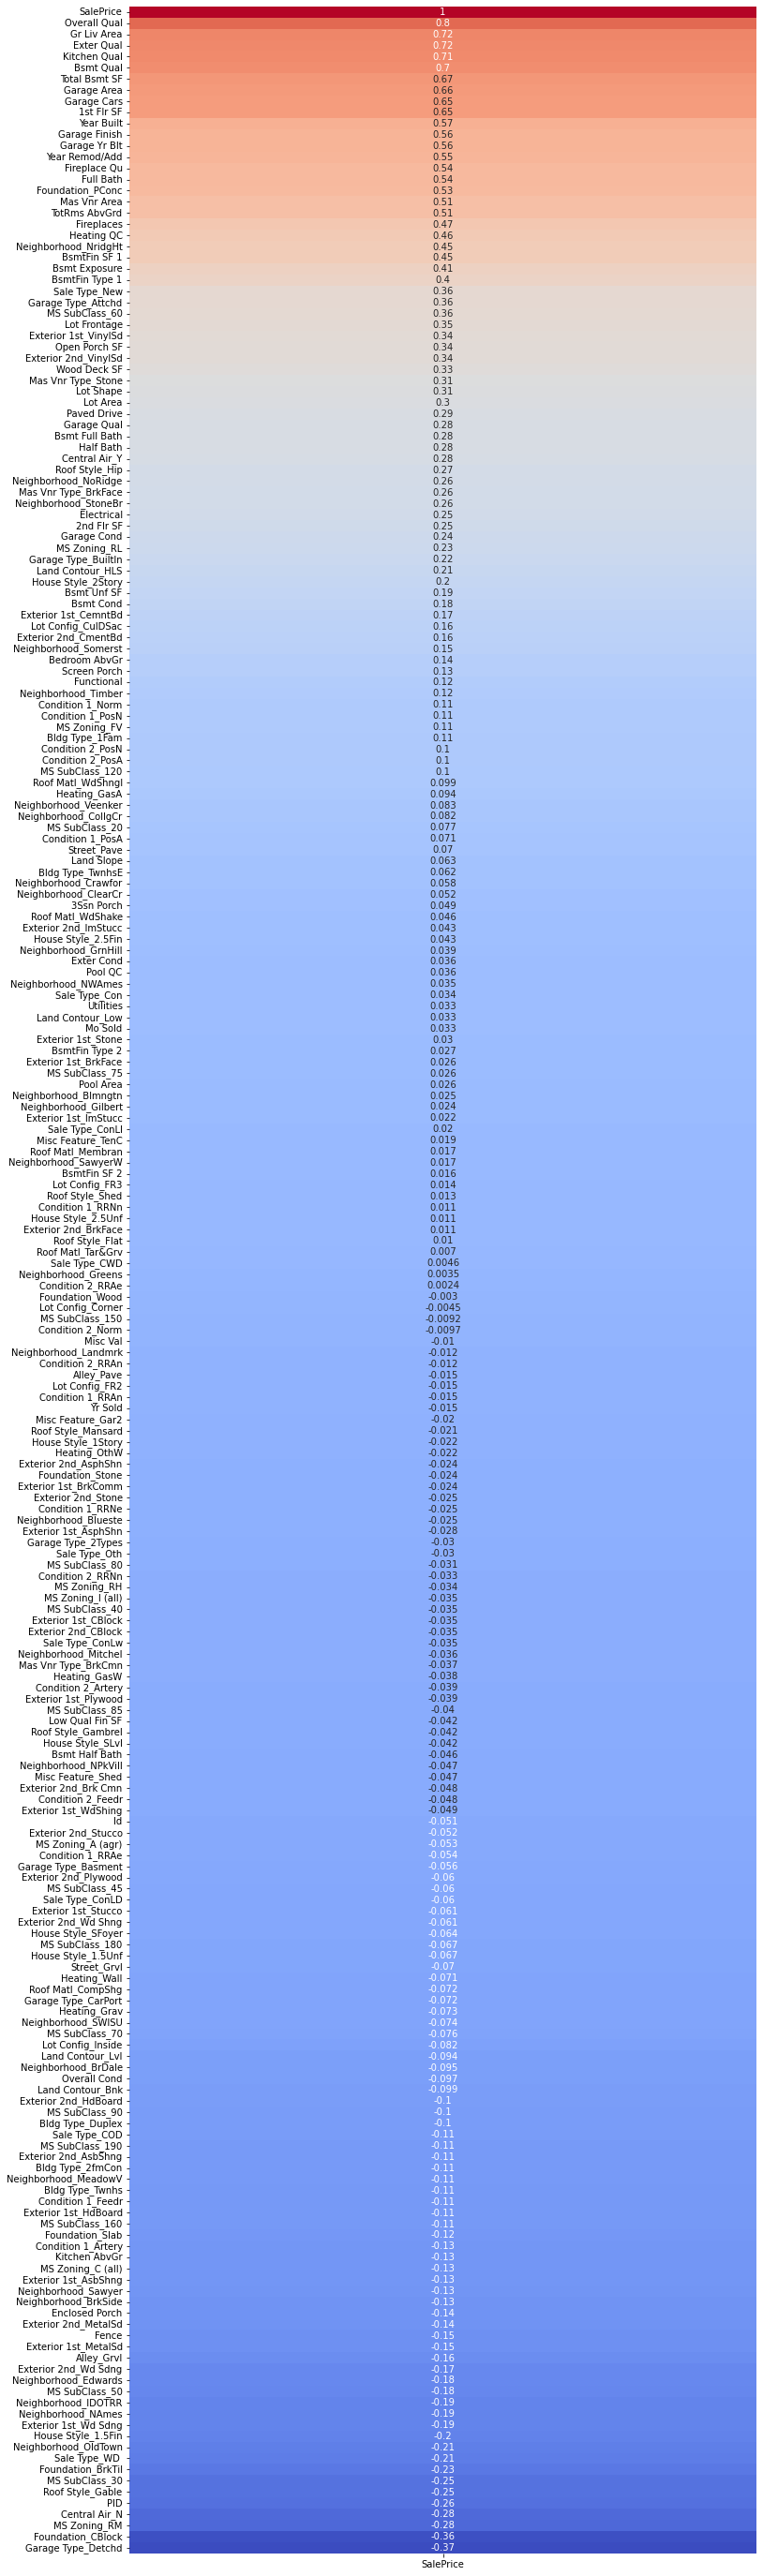

In [62]:
# Check correlation for all variables
plt.figure(figsize=(12,50))
sns.heatmap(housing.corr()[['SalePrice']].sort_values(by='SalePrice',
                                                      ascending=False),
            cmap='coolwarm', 
            annot=True, 
            cbar=False);


Based on our heatmap, our top 20, excluding SalePrice itself, positively correlated features are:

1. Overall Qual: 0.80
2. Gr Liv Area: 0.72
3. Kitchen Qual: 0.71
4. Exter Qual: 0.71
5. Bsmt Qual: 0.68
6. Total Bsmt SF: 0.67
7. Garage Area: 0.66
8. 1st Flr SF: 0.65
9. Garage Cars: 0.65
10. Year Built: 0.57
11. Garage Finish: 0.56
12. Year Remod/Add: 0.55
13. Garage Yr Blt: 0.56
14. Fireplace Qu: 0.54
15. Full Bath: 0.54
16. Foundation_PConc: 0.53
17. Mas Vnr Area: 0.51
18. TotRms AbvGrd: 0.51
19. Fireplaces: 0.47
20. Heating QC: 0.47

It seems like lots of features that pertain to quality are highly associated with SalePrice, which isn't very surprising.

Our top 10 most negatively correlated features are:

1. Neighborhood_OldTown: -0.21
2. Sale Type_WD: -0.21
3. Foundation_BrkTil: -0.23
4. MS SubClass_30: -0.25
5. Roof Style_Gable: -0.25
6. PID: -0.26
7. Central Air_N: -0.28
8. MS Zoning_RM: -0.28
9. Foundation_CBlock: -0.36
10. Garage Type_Detchd: -0.37

### Top 20 Heatmap



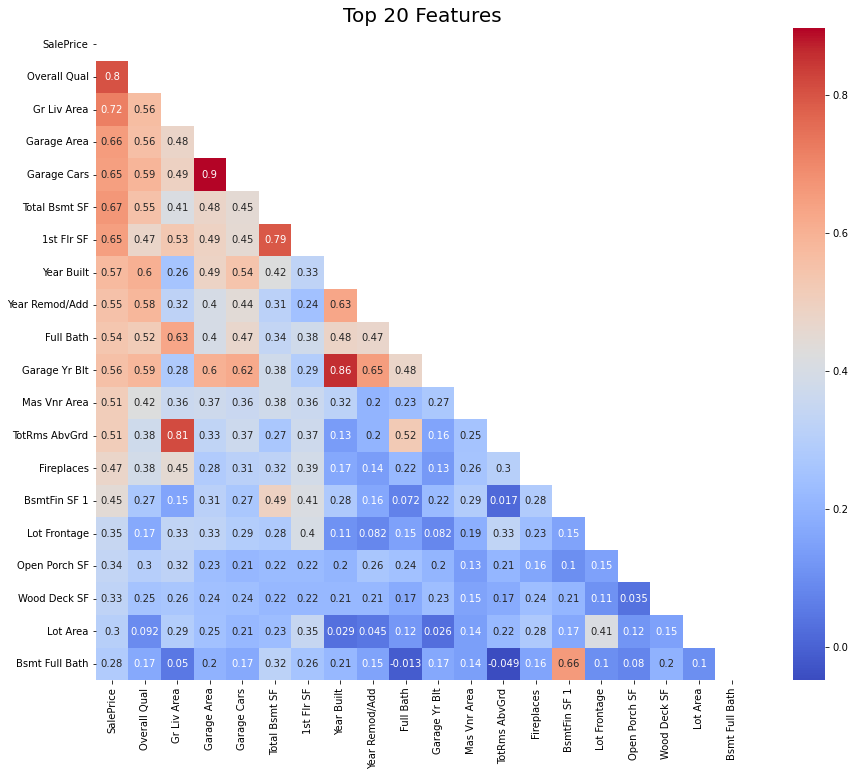

In [63]:
plt.figure(figsize=(16,12))
ax = sns.heatmap(housing[top_corr].corr(), cmap='coolwarm', mask=mask, square=True, annot=True)
plt.title('Top 20 Features', fontsize=20);

There are several features with molticollinearity. One of them are `Garage Cars` and `Garage Area`, `Garage Yr Blt` and `Year Built`.

Too much multicollinearity can be dangerous because it can lead to reduction of precision of our models. We will decrease the multicollinearity by removing redundant features.

In [64]:
# Create function to apply everything we did to train data to the test data
def train_to_test(df):    
    df['Pool QC'] = df['Pool QC'].fillna('None')
    df['Pool QC'] = df['Pool QC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'None':0})
    
    # One hot encoding for nominal variable
    df = pd.get_dummies(df, columns=['Misc Feature']).drop('Misc Feature_Othr', axis=1)
    
    # According to our boxplot, privacy is more important than the quality of wood.
    df['Fence'] = df['Fence'].fillna('None')
    df['Fence'] = df['Fence'].map({'GdPrv':3,'MnPrv':2,'GdWo':1,'MnWw':1,'None':0})
    df['Alley'] = df['Alley'].fillna('None')
    df = pd.get_dummies(df, columns=['Alley']).drop('Alley_None', axis=1)
    df['Fireplace Qu'] = df['Fireplace Qu'].fillna('None')
    df['Fireplace Qu'] = df['Fireplace Qu'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0})

    # Function to estimate lot frontage based on average of houses in neighborhood or township + section
    def lot_frontage_gen(row):
        if np.isnan(row['Lot Frontage']):
            neighborhood = row['Neighborhood']
            nbrhd_std = df[df['Neighborhood'] == neighborhood]['Lot Frontage'].std()
            lot_frontage_mean = df[df['Neighborhood'] == neighborhood]['Lot Frontage'].mean()

            try:
                # Add in slight randomness to prevent understimation of variance
                row['Lot Frontage'] = lot_frontage_mean + np.random.randint(-nbrhd_std, nbrhd_std) / 1.25

            # If neighborhood is NAN
            except:
                pid = str(row['PID'])
                print(pid, '-- Neighborhood N/A -- imputing township average')
                sliced_pid = pid[0:3]
                lot_frontage_mean = df[df['PID'].astype(str).str.contains(sliced_pid)]['Lot Frontage'].mean()
                row['Lot Frontage'] = lot_frontage_mean

        return row
    df = df.apply(lot_frontage_gen, axis=1)
    
    # Fix ordinal garage variables
    df['Garage Type'] = df['Garage Type'].fillna('None')
    df['Garage Finish'] = df['Garage Finish'].fillna('None')
    df['Garage Qual'] = df['Garage Qual'].fillna('None')
    df['Garage Cond'] = df['Garage Cond'].fillna('None')
    
    # Use one hot encoding for nominal feature -- Garage Type
    df = pd.get_dummies(df, columns=['Garage Type']).drop('Garage Type_None', axis=1)
    
    # Impute Garage Yr Blt with values from House Year Built
    df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(df['Year Built'])
    df['Garage Cond'] = df['Garage Cond'].map({'Ex':2,'Gd':1,'TA':0,'None':-0.5,'Fa':-0.5,'Po':-1,})
    df['Garage Qual'] = df['Garage Qual'].map({'Ex':2,'Gd':1,'TA':0,'None':-0.5,'Fa':-0.5,'Po':-1,})
    df['Garage Finish'] = df['Garage Finish'].map({'Fin':3,'RFn':2,'Unf':1,'None':0})

    # Fix ordinal basement variables
    df['Bsmt Qual'] = df['Bsmt Qual'].fillna('None')
    df['Bsmt Cond'] = df['Bsmt Cond'].fillna('None')
    df['Bsmt Exposure'] = df['Bsmt Exposure'].fillna('None')
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].fillna('None')
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].fillna('None')
    
    # Encode ordinal variables as integers
    df['Bsmt Cond'] = df['Bsmt Cond'].map({'Ex':2,'Gd':1,'TA':0, 'Fa':-0.25, 'None':-0.5, 'Po':-1})
    df['Bsmt Exposure'] = df['Bsmt Exposure'].map({'Gd':3,'Av':2,'Mn':1,'No':0,'None':0})
    
    ## According to our boxplot, basements of excellent quality (or height) tend to have much higher sales prices.
    df['Bsmt Qual'] = df['Bsmt Qual'].map({'Ex':4,'Gd':2,'TA':0, 'Fa':-0.25, 'None':-0.5, 'Po':-1})
    
    ## Only good quality basements seem to have a strong correlation with higher sales prices.
    df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map({'GLQ':3,'ALQ':2,'BLQ':1,'Rec':1,'LwQ':0.5,'Unf':0,'None':-0.5})
    df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map({'GLQ':3,'ALQ':2,'BLQ':1,'Rec':1,'LwQ':0.5,'Unf':0,'None':-0.5})
    
    df['Mas Vnr Type'] = df['Mas Vnr Type'].fillna('None')
    
    df = pd.get_dummies(data=df, columns=['Mas Vnr Type']).drop('Mas Vnr Type_None', axis=1)
    df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)
    
    df['Lot Shape'] = df['Lot Shape'].map({'IR1':1,'IR2':1,'IR3':1,'Reg':0})
    df['Land Slope'] = df['Land Slope'].map({'Gtl':0,'Mod':1,'Sev':1})
   
    df['Utilities'] = df['Utilities'].map({'AllPub':0,'NoSewr':-1,'NoSeWa':-1})
    df['Heating QC'] = df['Heating QC'].map({'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0})
    df['Electrical'] = df['Electrical'].map({'SBrkr':1,'FuseA':0.5,'FuseF':0,'FuseP':0,'Mix':0})
    df['Electrical'] = df['Electrical'].fillna(0)
   
    df['Exter Qual'] = df['Exter Qual'].map({'Ex':2,'Gd':1,'TA':0,'Fa':-1,'Po':-2})
    df['Exter Cond'] = df['Exter Cond'].map({'Ex':2,'Gd':1,'TA':0,'Fa':-1,'Po':-2})
    df['Kitchen Qual'] = df['Kitchen Qual'].map({'Ex':4.5,'Gd':3,'TA':2,'Fa':1,'Po':0})
    df['Functional'] = df['Functional'].map({'Typ':1,'Min1':0,'Min2':0,'Mod':-2,'Maj1':-3,'Maj2':-3,'Sev':-6,'Sal':-8})
    df['Paved Drive'] = df['Paved Drive'].map({'Y':1,'P':0.5,'N':0})

    # Collect remaining features and one hot encode
    cat_features = [col for col in df.select_dtypes(include=['category', 'object']).columns]
    df = pd.get_dummies(data=df, columns=cat_features)
    
    # Numerical to categorical
    df = pd.get_dummies(data=df, columns=['MS SubClass'])
    
    return df

In [65]:
test = train_to_test(test)

In [66]:
housing.isnull().sum()[housing.isnull().sum() > 0],\
test.isnull().sum()[test.isnull().sum() > 0]

(Series([], dtype: int64), Series([], dtype: int64))

In [67]:
housing.to_csv('./datasets/housing_cleaned.csv', index=False)

In [68]:
test.to_csv('./datasets/test_cleaned.csv', index=False)

In [69]:
housing = pd.read_csv('./datasets/housing_cleaned.csv')
test = pd.read_csv('./datasets/test_cleaned.csv')

# Feature Selection

In [70]:
housing.shape

(2049, 228)

We increased the number of features from 81 to 228 by getting dummies to many features. This may lead to some increase in accuracy to our modeling, but the RMSE greatly increased even after regularization.

## Dealing with Multicollinearity

High correlation between features probably means that they carry similar information. I created a table of features that have similar information, then dropped one if they provided identical information and if not, I kept the one that had a higher correlation with `SalePrice`.

In [71]:
# Create matrix
corr_matrix = housing.corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1)
                  .astype(np.bool_))
                  .stack()
                  .sort_values(ascending=False))

# Convert to dataframe
corr_df = pd.DataFrame(sol.head(20)).reset_index()

# Rename columns
corr_df.columns = 'v1', 'v2', 'pair_corr'

In [72]:
def corr_target(row):
    row['v1_y_corr'] = housing.corr()['SalePrice'][row['v1']]
    row['v2_y_corr'] = housing.corr()['SalePrice'][row['v2']]
    return row

In [73]:
# Create df with pairwise correlation and correlation to target
corr_df = corr_df.apply(corr_target, axis=1)

In [74]:
corr_df.head(20)

,v1,v2,pair_corr,v1_y_corr,v2_y_corr
0,Central Air_N,Central Air_Y,1.000000,-0.277425,0.277425
1,Bldg Type_Duplex,MS SubClass_90,1.000000,-0.103716,-0.103716
2,Street_Grvl,Street_Pave,1.000000,-0.069850,0.069850
3,Exterior 1st_CemntBd,Exterior 2nd_CmentBd,0.988254,0.168318,0.157748
4,Bldg Type_2fmCon,MS SubClass_190,0.977762,-0.111444,-0.109283
5,Exterior 1st_VinylSd,Exterior 2nd_VinylSd,0.977557,0.342156,0.337571
6,Exterior 1st_MetalSd,Exterior 2nd_MetalSd,0.976456,-0.149919,-0.139405
7,Id,Yr Sold,0.975765,-0.051416,-0.015174
8,House Style_SLvl,MS SubClass_80,0.954550,-0.042126,-0.031443
9,Roof Style_Gable,Roof Style_Hip,0.948244,-0.250019,0.266010


In [75]:
housing = housing.rename(columns={'Exterior 2nd_Wd Shng': 'Exterior 2nd_WdShing'})
housing = housing.rename(columns={'Exterior 2nd_Brk Cmn': 'Exterior 2nd_BrkComm'})
housing = housing.rename(columns={'Exterior 2nd_CmentBd': 'Exterior 2nd_CemntBd'})

In [76]:
ext_feats = housing.columns[housing.columns.str.contains('Exterior 1st')]
ext_feats

Index(['Exterior 1st_AsbShng', 'Exterior 1st_AsphShn', 'Exterior 1st_BrkComm',
       'Exterior 1st_BrkFace', 'Exterior 1st_CBlock', 'Exterior 1st_CemntBd',
       'Exterior 1st_HdBoard', 'Exterior 1st_ImStucc', 'Exterior 1st_MetalSd',
       'Exterior 1st_Plywood', 'Exterior 1st_Stone', 'Exterior 1st_Stucco',
       'Exterior 1st_VinylSd', 'Exterior 1st_Wd Sdng', 'Exterior 1st_WdShing'],
      dtype='object')

In [77]:
# Create interaction columns for Exterior features
for i in ext_feats:
    ext_type = i.split('_')[1]
    housing[f'Ext{ext_type}'] = housing[f'Exterior 1st_{ext_type}'] \
    * housing[f'Exterior 2nd_{ext_type}']
    housing = housing.drop([f'Exterior 1st_{ext_type}', \
                            f'Exterior 2nd_{ext_type}'], axis=1)

In [78]:
# Dropping : perfect pairwise correlation score of 1
housing = housing.drop(['Street_Grvl', 'MS SubClass_190', 'Central Air_N'], axis=1)
# Dropping : perfect correlation with Bldg Type_Duplex
housing = housing.drop(['MS SubClass_90'], axis=1)
# Dropping : Yr Sold has a higher correlation to sale price
housing = housing.drop(['Id'], axis=1)
# Dropping :  House Style_SLevel but lower
housing = housing.drop('MS SubClass_80', axis=1)
# Dropping : House Style_1.5Fin but lower
housing = housing.drop('MS SubClass_50', axis=1)
# Dropping : House Style_1.5Unf but lower
housing = housing.drop('MS SubClass_45', axis=1)
# This was the only polynomial feature that helped with model accuracy
housing['Garage QualCond'] = housing['Garage Qual'] * housing['Garage Cond']
housing = housing.drop(['Garage Qual', 'Garage Cond'], axis=1)
# Dropping : almost the same as Yr built
housing = housing.drop('Garage Yr Blt', axis=1)

## Low Variance

Lots of our features have the same value. This means that the features are mostly constant and does not improve the model's performance.

In [79]:
low_var_list = housing.var().sort_values(ascending=False)
low_var_list = low_var_list[low_var_list.values < 0.009]

In [80]:
# Combining categories with small sale type numbers to make them stastically significant
housing['Combined Sale Type_Con'] = housing['Sale Type_ConLw'] + \
housing['Sale Type_ConLI'] + housing['Sale Type_Con'] + housing['Sale Type_ConLD']

In [81]:
# Dropping features with low variance (<0.009)
low_var_drop_list = [item for item in low_var_list.index]
housing = housing.drop(low_var_drop_list, axis=1)

In [82]:
low_var_list.head()

Neighborhood_Veenker    0.008232
Sale Type_ConLD         0.008232
Neighborhood_NPkVill    0.008232
MS SubClass_75          0.007751
Roof Matl_Tar&Grv       0.007271
dtype: float64

In [83]:
housing[['PID']]

,PID
0,533352170
1,531379050
2,535304180
3,916386060
4,906425045
...,...
2044,921126030
2045,905377130
2046,909253010
2047,535179160


In [84]:
housing.columns.value_counts()

PID                       1
House Style_1.5Fin        1
Neighborhood_SawyerW      1
Neighborhood_Somerst      1
Neighborhood_StoneBr      1
                         ..
Fence                     1
Misc Val                  1
Mo Sold                   1
Yr Sold                   1
Combined Sale Type_Con    1
Length: 147, dtype: int64

## Further Feature Elimination

I want to use Recursive feature elimination which fits a model and removes the weakest features until it reaches a specified number of features. After eliminating the weakest feature, the model is then refit then the weakest feature is reevaluated, then removed again.

In [85]:
features = [col for col in housing._get_numeric_data()\
            .columns if col !='SalePrice']
features
X = housing[features]
y = housing['SalePrice']

In [86]:
model = LinearRegression()
rfe = RFE(model, n_features_to_select=120)
rfe_fit = rfe.fit(X, y)

In [87]:
rfe_df = pd.DataFrame(columns=['Feature', 'Ranking'])
rfe_df['Feature'] = X.columns
rfe_df['Ranking'] = rfe_fit.ranking_

In [88]:
rfe_df.sort_values(by='Ranking', ascending=False).head(10)

,Feature,Ranking
0,PID,27
50,Misc Val,26
25,Low Qual Fin SF,25
2,Lot Area,24
45,3Ssn Porch,23
44,Enclosed Porch,22
38,Garage Finish,21
42,Wood Deck SF,20
18,BsmtFin SF 2,19
19,Bsmt Unf SF,18


In [89]:
rfe_drop_list = X.columns[~rfe_fit.get_support()]
rfe_drop_list

Index(['PID', 'Lot Area', 'Year Built', 'Year Remod/Add', 'Mas Vnr Area',
       'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Half Bath', 'Garage Finish', 'Garage Area', 'Wood Deck SF',
       'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch',
       'Pool Area', 'Fence', 'Misc Val', 'MS SubClass_70', 'ExtMetalSd'],
      dtype='object')

In [90]:
# Dropping features ranked as unimportant by RFE
housing = housing.drop(rfe_drop_list, axis=1)

In [91]:
def train_to_test_2(df):
    df['Garage QualCond'] = df['Garage Qual'] * df['Garage Cond']
    df = df.drop(['Garage Qual', 'Garage Cond'], axis=1)
    df['Foundation_Other'] = df['Foundation_Slab'] + df['Foundation_Stone'] + df['Foundation_Wood']

    df = df.rename(columns={'Exterior 2nd_Wd Shng': 'Exterior 2nd_WdShing'})
    df = df.rename(columns={'Exterior 2nd_Brk Cmn': 'Exterior 2nd_BrkComm'})
    df = df.rename(columns={'Exterior 2nd_CmentBd': 'Exterior 2nd_CemntBd'})

    ext_feats = df.columns[df.columns.str.contains('Exterior 1st')]
    
    for i in ext_feats:
        ext_type = i.split('_')[1]
        df[f'Ext{ext_type}'] = df[f'Exterior 1st_{ext_type}'] * df[f'Exterior 2nd_{ext_type}']
        df = df.drop([f'Exterior 1st_{ext_type}', f'Exterior 2nd_{ext_type}'], axis=1)


    df = df.drop(['Street_Grvl', 'MS SubClass_190', 'Central Air_N'], axis=1)
    df = df.drop(['MS SubClass_90'], axis=1)
    df = df.drop('MS SubClass_80', axis=1)
    df = df.drop('MS SubClass_50', axis=1)
    df = df.drop('MS SubClass_45', axis=1)
    df = df.drop('Garage Yr Blt', axis=1)
    df['Combined Sale Type_Con'] = df['Sale Type_ConLw'] + df['Sale Type_ConLI'] + df['Sale Type_Con'] + df['Sale Type_ConLD']
    
    low_var_drop_list = [item for item in low_var_list.index]
    df = df.drop(low_var_drop_list, axis=1, errors='ignore')
    df = df.drop(rfe_drop_list, axis=1)
    df = df.drop(['Id'], axis=1)
    
    return df

In [92]:
test = train_to_test_2(test)

In [93]:
test.shape

(878, 130)

In [94]:
housing.shape

(2049, 121)

In [95]:
[x for x in housing if x not in test]

['SalePrice']

In [96]:
[x for x in test if x not in housing]

['Mas Vnr Type_CBlock',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Exterior 2nd_CBlock',
 'Exterior 2nd_ImStucc',
 'Exterior 2nd_Other',
 'Heating_Floor',
 'Sale Type_VWD',
 'Foundation_Other',
 'ExtPreCast']

In [97]:
# Drop 

test = test.drop(['Mas Vnr Type_CBlock',
 'Roof Matl_Metal',
 'Roof Matl_Roll',
 'Exterior 2nd_CBlock',
 'Exterior 2nd_ImStucc',
 'Exterior 2nd_Other',
 'Heating_Floor',
 'Sale Type_VWD',
 'ExtPreCast'], axis = 1)

In [98]:
housing.shape

(2049, 121)

In [99]:
test.shape

(878, 121)

In [100]:
housing.to_csv('./datasets/housing_final.csv')
test.to_csv('./datasets/test_final.csv')

# Model Preparation

## Train Test Split

In [101]:
features = [col for col in housing._get_numeric_data().columns if col !='SalePrice']
X = housing[features]
y = housing['SalePrice']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [103]:
ss = StandardScaler()
ss.fit(X_train)

X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [104]:
lr = LinearRegression()

In [105]:
ridge = RidgeCV(alphas=np.linspace(1, 200, 100))

In [106]:
lasso = LassoCV(n_alphas=100)

In [107]:
enet_alphas = np.arange(0.5, 1.0, 0.005)
enet_ratio = 0.5
enet = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Model Evaluation

## Cross Validation

In [108]:
# Testing our linear regression model
lr_cv_scores = cross_val_score(lr, X_train_scaled, y_train, cv=5)
print('R2:', lr_cv_scores.mean())
lr_cv_mse_scores = -cross_val_score(lr, X_train_scaled, y_train,cv=5, scoring ='neg_mean_squared_error')
print('RSME:', lr_cv_mse_scores.mean() ** 0.5)

R2: 0.8604583860552097
RSME: 28947.516914518987


In [109]:
# Testing our ridge regression model
ridge_cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=5)
print('R2:', ridge_cv_scores.mean())
ridge_cv_mse_scores = -cross_val_score(ridge,X_train_scaled,y_train,cv=5, scoring ='neg_mean_squared_error')
print('RSME:', ridge_cv_mse_scores.mean() ** 0.5)

/Users/sangs/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/sangs/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/sangs/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/sangs/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/sangs/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


R2: 0.8622801818386081
RSME: 28756.57160558882


/Users/sangs/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)
/Users/sangs/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


In [110]:
# Testing our ridge regression model
lasso_cv_scores = cross_val_score(lasso, X_train_scaled, y_train, cv=5)
print('R2:', lasso_cv_scores.mean())
lasso_cv_mse_scores = -cross_val_score(lasso,X_train_scaled,y_train,cv=5, scoring ='neg_mean_squared_error')
print('RSME:', lasso_cv_mse_scores.mean() ** 0.5)

R2: 0.8625942813234975
RSME: 28751.09378622197


In [111]:
# Testing our elasticnet regression model
enet_cv_scores = cross_val_score(enet, X_train_scaled, y_train, cv=5)
print('R2:', enet_cv_scores.mean())
enet_cv_mse_scores = -cross_val_score(enet, X_train_scaled, y_train, cv=5, scoring ='neg_mean_squared_error')
print('RSME:', enet_cv_mse_scores.mean() ** 0.5)

R2: 0.8609585024530816
RSME: 28928.987913356195


It seems like our lasso model is doing slightly better than other models with a R2 value of 0.8632 and RMSE of 28679

## Standard Linear Regression

In [112]:
lr.fit(X_train_scaled,y_train)

print("Training R2(LR): " + str(lr.score(X_train_scaled,y_train)))
print("Testing R2(LR): " + str(lr.score(X_test_scaled,y_test)))
print("Estimate of Testing R2(LR): " + str(lr_cv_scores.mean()))

Training R2(LR): 0.8902310777018432
Testing R2(LR): 0.8696464371846293
Estimate of Testing R2(LR): 0.8604583860552097


In [113]:
print("Training RMSE(LR): " + str(np.sqrt(mean_squared_error(y_train, lr.predict(X_train_scaled)))))
print("Testing RMSE(LR): " + str(np.sqrt(mean_squared_error(y_test,lr.predict(X_test_scaled)))))
print("Estimate of Testing RMSE(LR): " + str(np.sqrt(lr_cv_mse_scores.mean())))

Training RMSE(LR): 25861.622336597742
Testing RMSE(LR): 29565.034583420562
Estimate of Testing RMSE(LR): 28947.516914518987


The model here is slightly overfit as we can see that the accuracy dropped from 0.8902 to 0.8695.

## Ridge Regression

In [114]:
ridge.fit(X_train_scaled, y_train);

/Users/sangs/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


In [115]:
# Optimal ridge alpha
best_ridge_alpha = ridge.alpha_
best_ridge_alpha

71.35353535353535

In [116]:
# Create new ridge model with optimal alpha and fit to training data
ridge = Ridge(alpha=best_ridge_alpha)
ridge.fit(X_train_scaled,y_train);

In [117]:
print("Training R2(ridge) " + str(ridge.score(X_train_scaled,y_train)))
print("Testing R2(ridge) " + str(ridge.score(X_test_scaled,y_test)))
print("Estimate of Testing R2(ridge) " + str(ridge_cv_scores.mean()))

Training R2(ridge) 0.8877057047202346
Testing R2(ridge) 0.8727201440980348
Estimate of Testing R2(ridge) 0.8622801818386081


In [118]:
print("Training MSE(Ridge) ", np.sqrt(mean_squared_error(y_train, ridge.predict(X_train_scaled))))
print("Testing MSE(Ridge) ", np.sqrt(mean_squared_error(y_test,ridge.predict(X_test_scaled))))
print("Estimate of Testing RMSE (Ridge) " + str(np.sqrt(ridge_cv_mse_scores.mean())))

Training MSE(Ridge)  26157.4203848976
Testing MSE(Ridge)  29214.386859834947
Estimate of Testing RMSE (Ridge) 28756.57160558882


Ridge is slightly better than the linear regression model. Still seems to be overfit.

In [119]:
# Fit LassoCV model to data
lasso.fit(X_train_scaled,y_train)

LassoCV()

In [120]:
# Generate best alpha
best_lasso_alpha = lasso.alpha_
best_lasso_alpha

409.92423001925744

In [121]:
# Create new lasso model with optimal alpha and fit to training data
lasso = Lasso(alpha=best_lasso_alpha)
lasso.fit(X_train_scaled, y_train)

Lasso(alpha=409.92423001925744)

In [122]:
print("Training R2(Lasso) ", lasso.score(X_train_scaled,y_train))
print("Testing R2(Lasso):", lasso.score(X_test_scaled,y_test))
print("Estimate of Testing R2(Lasso):", lasso_cv_scores.mean())

print("Training RMSE(Lasso):", np.sqrt(mean_squared_error(y_train, lasso.predict(X_train_scaled))))
print("Testing RMSE(Lasso):", np.sqrt(mean_squared_error(y_test, lasso.predict(X_test_scaled))))
print("Estimate of Testing RMSE(Lasso):", np.sqrt(lasso_cv_mse_scores.mean()))

Training R2(Lasso)  0.88424804563578
Testing R2(Lasso): 0.8712456790762874
Estimate of Testing R2(Lasso): 0.8625942813234975
Training RMSE(Lasso): 26557.074465799742
Testing RMSE(Lasso): 29383.11567033569
Estimate of Testing RMSE(Lasso): 28751.09378622197


Similar pattern to the ridge model.

## ElasticNet Regression

In [123]:
enet_alphas = np.arange(0.01, 1.0, 0.005)
enet_ratio = 0.5
enet = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5, max_iter=5_000)
enet = enet.fit(X_train_scaled, y_train)

In [124]:
enet_optimal_alpha = enet.alpha_
enet_optimal_alpha

0.18

In [125]:
# Create new enet model with optimal alpha and fit to training data
enet = ElasticNet(alpha=enet_optimal_alpha)
enet.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.18)

In [126]:
enet_cv_scores = cross_val_score(enet,X_train_scaled,y_train,cv=5)
enet_cv_scores.mean()

0.862291530971852

In [127]:
enet_cv_mse_scores = -cross_val_score(enet,X_train_scaled,y_train,cv=5, scoring ='neg_mean_squared_error')
np.sqrt(enet_cv_mse_scores.mean())

28757.877815836957

In [128]:
print('Training R2(ElasticNet):', enet.score(X_train_scaled,y_train))
print('Testing R2(ElasticNet):', enet.score(X_test_scaled,y_test))
print('Estimate of Testing R2(ElasticNet): ', enet_cv_scores.mean())

print('Training MSE(ElasticNet):', np.sqrt(mean_squared_error(y_train, enet.predict(X_train_scaled))))
print('Testing MSE(ElasticNet):', np.sqrt(mean_squared_error(y_test, enet.predict(X_test_scaled))))
print('Estimate of Testing RMSE(ElasticNet):', np.sqrt(enet_cv_mse_scores.mean()))


Training R2(ElasticNet): 0.8861391676987648
Testing R2(ElasticNet): 0.8718134780051924
Estimate of Testing R2(ElasticNet):  0.862291530971852
Training MSE(ElasticNet): 26339.240159697638
Testing MSE(ElasticNet): 29318.255183755587
Estimate of Testing RMSE(ElasticNet): 28757.877815836957


Still overfitting. Seems like they are all very similar in results, but either the ridge or the enet is better so far.

In [129]:
# Fit LassoCV model to data
lasso.fit(X_train_scaled,y_train)
ridge.fit(X_train_scaled,y_train)
enet.fit(X_train_scaled,y_train)
lr.fit(X_train_scaled,y_train)

LinearRegression()

Text(0.5, 1.0, 'Lasso Predictions of Sale Price vs Actual Sale Price')

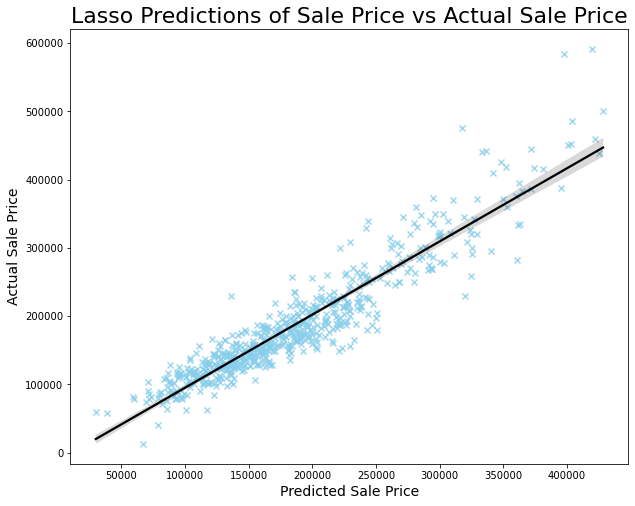

In [130]:
# Create scatterplot to show predicted values versus actual values
lasso_preds = lasso.predict(X_test_scaled)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train_scaled, x=lasso_preds, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Lasso Predictions of Sale Price vs Actual Sale Price', fontsize=22)

Text(0.5, 1.0, 'Residuals')

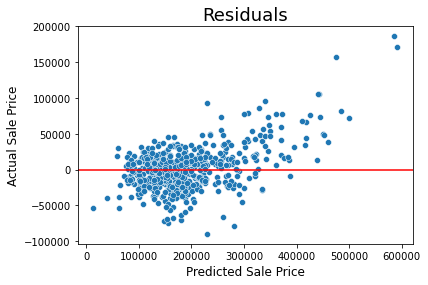

In [131]:
ax = sns.scatterplot(data=housing, x=y_test, y=y_test-lasso_preds)
ax.axhline(y=0, c='red')
plt.xlabel('Predicted Sale Price', fontsize=12)
plt.ylabel('Actual Sale Price', fontsize=12)
plt.title('Residuals', fontsize=18)

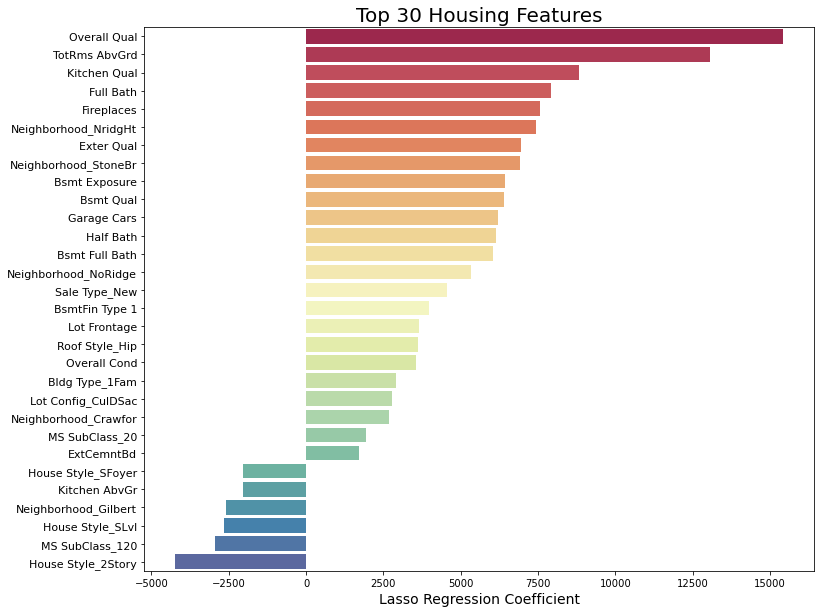

In [132]:
# Create dataframe of features, coefficients and absolute coefficients
lasso_df = pd.DataFrame(columns=['Feature', 'Coef', 'Abs Coef'])
lasso_df['Abs Coef'] = abs(lasso.coef_)
lasso_df['Coef'] = lasso.coef_
lasso_df['Feature'] = features

# Plot top 30 features (sorted by absolute regression coefficient)
plt.figure(figsize=(12,10))
data = lasso_df.sort_values(by='Abs Coef', ascending=False).head(30)[['Feature', 'Coef']] \
               .sort_values(by='Coef', ascending=False).reset_index(drop=True)
    
ax = sns.barplot(data=data, y='Feature', x='Coef', orient='h', palette='Spectral')
ax.set_ylabel('')
ax.set_yticklabels(data['Feature'], size=11)
ax.set_xlabel('Lasso Regression Coefficient', fontsize=14)
plt.title('Top 30 Housing Features', fontsize=20);